In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_hist(symbol, start, end):
    df = yf.download(symbol, start = start, end = end)[['High','Low','Adj Close']].rename(columns={'Adj Close':'Close'})
    df['ma'] = df['Close'].rolling(window=20).mean().round(2)
    df['std'] = df['Close'].rolling(window=20).std().round(2)
    df['lowerBB'] = df['ma'] - (df['std'] * 2).round(2)
    df['upperBB'] = df['ma'] + (df['std'] * 2).round(2)
    df = df.dropna()
    return df


In [3]:
def strategy(df):
    # Trade Entry (N-days = 80)
    df['long_entry'] = df.High > df.upperBB.shift(1) #(enter Long trade when daily High above upper bollinger band)
    df['short_entry'] = df.Low < df.lowerBB.shift(1) #(enter Short trade when daily Low below lower bollinger band)
    # Trade Exit
    df['long_exit'] = df.Low < df.ma.shift(1)   #(exit Long when Low below moving average)
    df['short_exit'] = df.High > df.ma.shift(1) #(exit Short when High above moving average)

    df['Position_Long'] = np.nan
    df.loc[df.long_entry,'Position_Long'] = 1
    df.loc[df.long_exit,'Position_Long'] = 0
    df['Position_Short'] = np.nan
    df.loc[df.short_entry,'Position_Short'] = -1
    df.loc[df.short_exit,'Position_Short'] = 0

    df = df.fillna(method='ffill')
    df['Signal'] = df.Position_Long + df.Position_Short
    df['daily_returns'] = np.log(df.Close/df.Close.shift(1))
    df['daily_strategy_returns'] = df['daily_returns'] * df.Signal.shift(1)

    df[['daily_strategy_returns','daily_returns']].dropna().cumsum().apply(np.exp).plot(figsize=(14,8), lw=3);

In [4]:
def bbs (symbol, stime, etime):
    
    df = get_hist(symbol, stime, etime)
    
    #  style
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    
    prices = df.loc[stime:etime]['Close']
    Ubb = df.loc[stime:etime]['upperBB']
    Dbb = df.loc[stime:etime]['lowerBB']
    ma = df.loc[stime:etime]['ma']
    
    ax.fill_between(df.loc[stime:etime].index, Ubb, Dbb, color='grey')

    # Plot Closing Price and Moving Averages
    ax.plot(df.loc[stime:etime].index, prices, color='blue', lw=2)
    ax.plot(df.loc[stime:etime].index, ma , color='black', lw=2)

    # Title & Show the Image
    ax.set_title(f'20 Day Bollinger Band For {symbol} ({stime} -> {etime})')
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price')
    plt.show()
    
    df['ma'] = df['Close'].rolling(window=80).mean().round(2)
    df['std'] = df['Close'].rolling(window=80).std().round(2)
    df = df.dropna()
    # 80 Day Bollinger Band for df
    df.loc[stime:etime][['Close', 'ma', 'upperBB', 'lowerBB']].plot(figsize=(14,6), lw=1.5)
    plt.title(f'80 Day Bollinger Band for {symbol}')
    plt.ylabel('Price')
    plt.show()
    strategy(df)
    

[*********************100%***********************]  1 of 1 downloaded


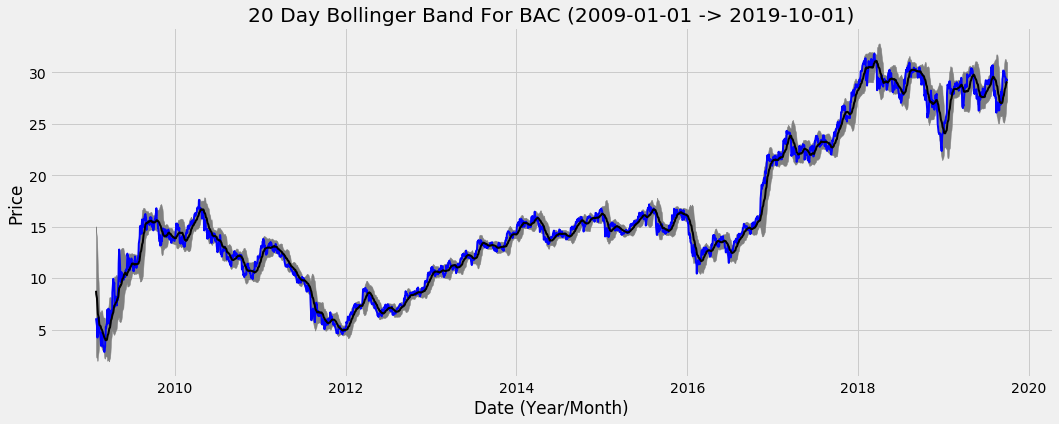

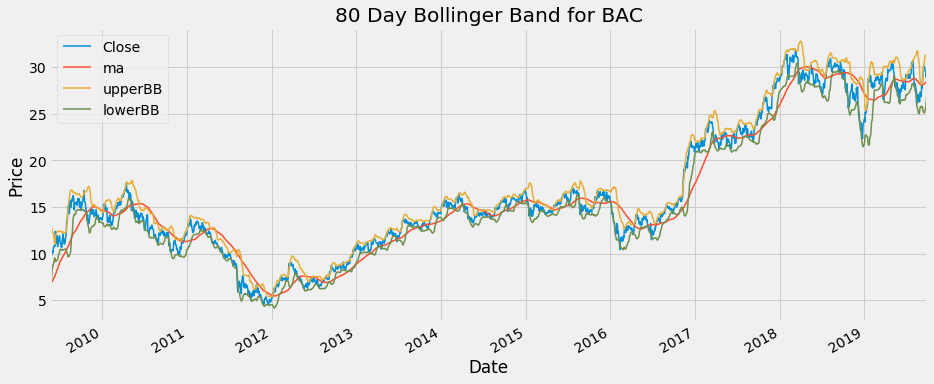

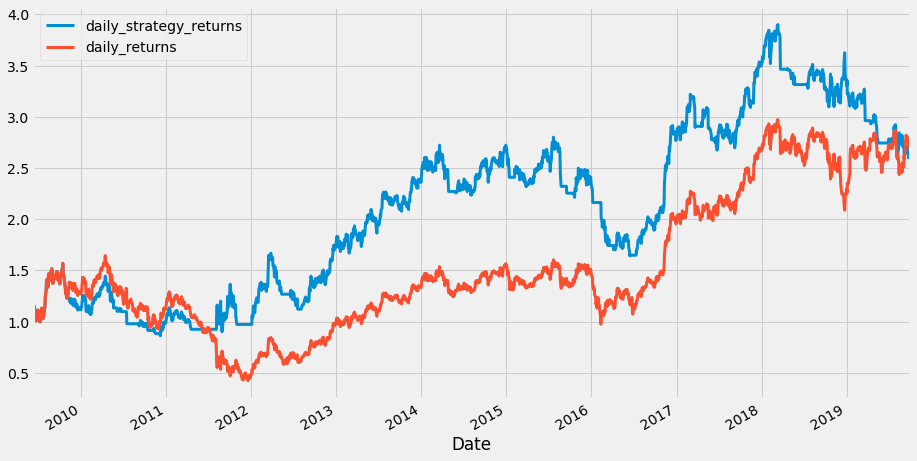

In [5]:
bbs('BAC','2009-01-01','2019-10-01')